## Analisis de errores: Producto de matrices

**Autor**: Jesús del Hoyo

**Fecha**:   29/10/2018

**Objetivo**: Ecograb project, polariscope callibration

**Explicación**:

En este pequeño archivo, voy a intentar comprobar cómo se propagan los errores de una matriz de Mueller o un vector de Stokes al multiplicarse. Incluiré dentro de los casos estudiados algunos muy similares a nuestros casos experimentales, y también estudiaré cómo afectan estos errores tanto al cálculo de la matriz inversa (o pseudoinversa) como a los parámetros medidos en la descomposición polar.

El error en la matriz de Mueller lo definiré como la norma de Frobenius de la resta de matrices (en la literatura usan a veces la norma infinita (maximo módulo de los vectores columna) o la norma 2 (maximo modulo Mx con x unitario)). Para poder comparar correctamente entre vectores de Stokes y Matrices de Mueller, dividiré el error entre el número de elementos. de esa manera, en vez de trabajar con un error de matriz, trabajaremos con un error del elemento de matriz.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib widget

In [2]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_2d, generate_even_distribution
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting
from matplotlib.colors import LogNorm
from matplotlib import ticker, colors


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import polarimeter.polarimeter as opsys
import numpy as np
import os

C:\Users\Jesus\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Producto de matrices puras

Empezare calculando el error en el producto usando solo matrices. Empleare tanto polarizadores como retardadores, con parámetros parecidos a los que medimos en nuestros elementos.

In [5]:
tic = time.time()
# Espacio de medida
Nerrores = 25
Naverages = 500
Ntests = 9
(min_angulo, max_angulo) = (0, 180*degrees)
(min_error, max_error) = (0, 0.02)
(min_p1, max_p1) = (0.8, 1)
(min_p2, max_p2) = (0, 0.2)
(min_chi, max_chi) = (-5*degrees, 5*degrees)
(min_delay, max_delay) = (75*degrees, 95*degrees)
factor = 0.246
# arrays
error_array = np.linspace(min_error, max_error, Nerrores)
result = np.zeros([Ntests,Nerrores])

# Main loop
for indE, error in enumerate(error_array):
    for indTipo in range(Ntests):
        average_array = np.zeros(Naverages)
        for indAv in range(Naverages):
            # Crear parametros aleatorios
            (p1, p3, p5, p7) = min_p1 + (max_p1-min_p1)*np.random.rand(4)
            (p2, p4, p6, p8) = min_p2 + (max_p2-min_p2)*np.random.rand(4)
            (fi1, fi2, fi3, fi4) = min_angulo + (max_angulo-min_angulo)*np.random.rand(4)
            (chi1, chi2, chi3, chi4) = min_chi + (max_chi-min_chi)*np.random.rand(4)
            (delay1, delay2, delay3, delay4) = min_delay + (max_delay-min_delay)*np.random.rand(4)
            # Crear matrices correctas
            Mp1 = ps.general_diattenuator_parvect(p1, p2, fi1, chi1, carac=False)
            Mp2 = ps.general_diattenuator_parvect(p3, p4, fi2, chi2, carac=False)
            Mp3 = ps.general_diattenuator_parvect(p5, p6, fi3, chi3, carac=False)
            Mp4 = ps.general_diattenuator_parvect(p7, p8, fi4, chi4, carac=False)
            Mr1 = ps.general_retarder_parvect(delay1, fi1, chi1, carac=False)
            Mr2 = ps.general_retarder_parvect(delay2, fi2, chi2, carac=False)
            Mr3 = ps.general_retarder_parvect(delay3, fi3, chi3, carac=False)
            Mr4 = ps.general_retarder_parvect(delay4, fi4, chi4, carac=False)
            # Crear matrices con errores
            Mp1_error = Mp1 + error/factor * np.matrix(np.random.randn(4,4))
            Mp2_error = Mp2 + error/factor * np.matrix(np.random.randn(4,4))
            Mp3_error = Mp3 + error/factor * np.matrix(np.random.randn(4,4))
            Mp4_error = Mp4 + error/factor * np.matrix(np.random.randn(4,4))
            Mr1_error = Mr1 + error/factor * np.matrix(np.random.randn(4,4))
            Mr2_error = Mr2 + error/factor * np.matrix(np.random.randn(4,4))
            Mr3_error = Mr3 + error/factor * np.matrix(np.random.randn(4,4))
            Mr4_error = Mr4 + error/factor * np.matrix(np.random.randn(4,4))
            # Multiply them depending on the iteration index
            if indTipo == 0:
                Mtot = Mp1 * Mp2
                Merr = Mp1_error * Mp2_error
            elif indTipo == 1:
                Mtot = Mp1 * Mr2
                Merr = Mp1_error * Mr2_error
            elif indTipo == 7:
                Mtot = Mr1 * Mp2
                Merr = Mr1_error * Mp2_error
            elif indTipo == 2:
                Mtot = Mr1 * Mr2
                Merr = Mr1_error * Mr2_error
            elif indTipo == 3:
                Mtot = Mp1 * Mp2 * Mp3 * Mp4
                Merr = Mp1_error * Mp2_error * Mp3_error * Mp4_error
            elif indTipo == 4:
                Mtot = Mp1 * Mp2 * Mp3 * Mr4
                Merr = Mp1_error * Mp2_error * Mp3_error * Mr4_error
            elif indTipo == 5:
                Mtot = Mp1 * Mp2 * Mr3 * Mr4
                Merr = Mp1_error * Mp2_error * Mr3_error * Mr4_error
            elif indTipo == 8:
                Mtot = Mp1 * Mr2 * Mr3 * Mp4
                Merr = Mp1_error * Mr2_error * Mr3_error * Mp4_error
            elif indTipo == 6:
                Mtot = Mp1 * Mr2 * Mr3 * Mr4
                Merr = Mp1_error * Mr2_error * Mr3_error * Mr4_error
            elif indTipo == 9:
                Mtot = Mr1 * Mr2 * Mr3 * Mr4
                Merr = Mr1_error * Mr2_error * Mr3_error * Mr4_error
            # Calculate error
            average_array[indAv] = np.linalg.norm(Mtot-Merr, ord='fro')/16
        # Average the result
        result[indTipo, indE] = np.mean(average_array)

toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

Elapsed time is: 1486.58100009


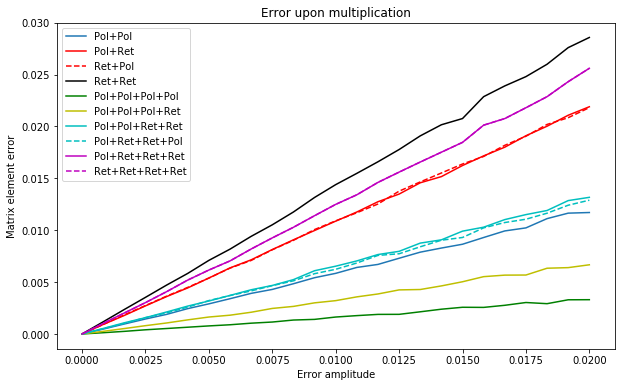

In [6]:
# Plot the result
plt.figure(figsize=(10,6))
plt.plot(error_array, result[0,:])
plt.plot(error_array, result[1,:],'r')
plt.plot(error_array, result[7,:],'r--')
plt.plot(error_array, result[2,:],'k')
plt.plot(error_array, result[3,:],'g')
plt.plot(error_array, result[4,:],'y')
plt.plot(error_array, result[5,:],'c')
plt.plot(error_array, result[8,:],'c--')
plt.plot(error_array, result[6,:],'m')
plt.plot(error_array, result[6,:],'m--')
plt.xlabel("Error amplitude")
plt.ylabel("Matrix element error")
plt.title("Error upon multiplication")
leg = ['Pol+Pol','Pol+Ret','Ret+Pol','Ret+Ret', 'Pol+Pol+Pol+Pol', 'Pol+Pol+Pol+Ret',
      'Pol+Pol+Ret+Ret', 'Pol+Ret+Ret+Pol', 'Pol+Ret+Ret+Ret', 'Ret+Ret+Ret+Ret', 'Ret+Ret+Ret+Ret']
plt.legend(leg)

## Casos experimentales

Ahora vamos a repetirlo con casos experimentales: Ley de Malus, generador de estados, analizador de estados, etc.

In [7]:
tic = time.time()
# Espacio de medida
Nerrores = 25
Naverages = 700
Ntests = 5
(min_angulo, max_angulo) = (0, 180*degrees)
(min_error, max_error) = (0, 0.02)
(min_p1, max_p1) = (0.8, 1)
(min_p2, max_p2) = (0, 0.2)
(min_chi, max_chi) = (-5*degrees, 5*degrees)
(min_delay, max_delay) = (75*degrees, 95*degrees)
(min_polar, max_polar) = (0.8, 1)
(min_circ, max_circ) = (0.8, 1)
factor_Mueller = 0.246
factor_Stokes = 0.47
# arrays
error_array = np.linspace(min_error, max_error, Nerrores)
result = np.zeros([Ntests,Nerrores])

# Main loop
for indE, error in enumerate(error_array):
    for indTipo in range(Ntests):
        average_array = np.zeros(Naverages)
        for indAv in range(Naverages):
            # Crear parametros aleatorios
            (p1, p3) = min_p1 + (max_p1-min_p1)*np.random.rand(2)
            (p2, p4) = min_p2 + (max_p2-min_p2)*np.random.rand(2)
            (fi1, fi2, fi3, fi4, fi5) = min_angulo + (max_angulo-min_angulo)*np.random.rand(5)
            (chi1, chi2, chi3, chi4) = min_chi + (max_chi-min_chi)*np.random.rand(4)
            (delay1, delay2) = min_delay + (max_delay-min_delay)*np.random.rand(2)
            polar = min_polar + (max_circ-min_polar)*np.random.rand(1)
            circ = min_circ + (max_circ-min_circ)*np.random.rand(1)
            # Crear matrices correctas
            Mp1 = ps.general_diattenuator_parvect(p1, p2, fi1, chi1, carac=False)
            Mp2 = ps.general_diattenuator_parvect(p3, p4, fi2, chi2, carac=False)
            Mr1 = ps.general_retarder_parvect(delay1, fi3, chi3, carac=False)
            Mr2 = ps.general_retarder_parvect(delay2, fi4, chi4, carac=False)
            Stokes = ps.polarized_light(
                intensity=1, angle=fi5, phase=circ, pol_degree=polar, is_degree=True)
            # Crear matrices con errores
            Mp1_error = Mp1 + error/factor_Mueller * np.matrix(np.random.randn(4,4))
            Mp2_error = Mp2 + error/factor_Mueller * np.matrix(np.random.randn(4,4))
            Mr1_error = Mr1 + error/factor_Mueller * np.matrix(np.random.randn(4,4))
            Mr2_error = Mr2 + error/factor_Mueller * np.matrix(np.random.randn(4,4))
            Stokes_error = Stokes + error/factor_Mueller * np.matrix(np.random.randn(4,1))
            # Multiply them depending on the iteration index
            if indTipo == 0: # Ley de Malus (calibracion polarizadores)
                Mtot = Mp1 * (Mp2 * Stokes)
                Merr = Mp1_error * (Mp2_error * Stokes_error)
                factor_div = 4
            elif indTipo == 1: # Generador de estados
                Mtot = Mr1 * (Mp2 * Stokes)
                Merr = Mr1_error * (Mp2_error * Stokes_error)
                factor_div = 4
            elif indTipo == 2: # Analizador de estados
                Mtot = Mr1 * Mp2
                Merr = Mr1_error * Mp2_error
                factor_div = 16
            elif indTipo == 3: # Calibracion retardador
                Mtot = Mp1 * Mr2 * Mp2
                Merr = Mp1_error * Mr2_error * Mp2_error
                factor_div = 16
            elif indTipo == 4: # Calibracion segundo retardador
                Mtot = Mp1 * Mr2 * Mr1 * Mp2
                Merr = Mp1_error * Mr2_error * Mr1_error * Mp2_error
                factor_div = 16
            # Calculate error
            average_array[indAv] = np.linalg.norm(Mtot-Merr, ord='fro')/factor_div
        # Average the result
        result[indTipo, indE] = np.mean(average_array)

toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

Elapsed time is: 630.680000067


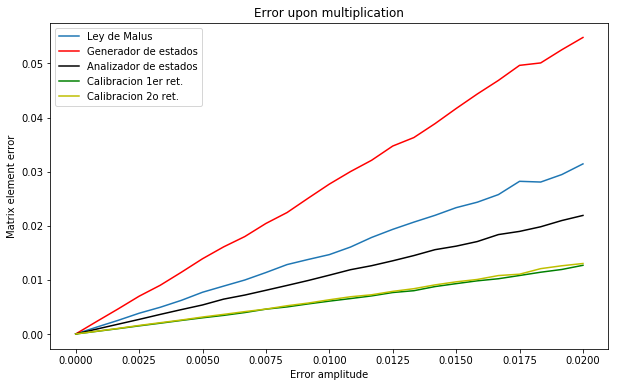

In [8]:
# Plot the result
plt.figure(figsize=(10,6))
plt.plot(error_array, result[0,:])
plt.plot(error_array, result[1,:],'r')
plt.plot(error_array, result[2,:],'k')
plt.plot(error_array, result[3,:],'g')
plt.plot(error_array, result[4,:],'y')
plt.xlabel("Error amplitude")
plt.ylabel("Matrix element error")
plt.title("Error upon multiplication")
leg = ['Ley de Malus','Generador de estados','Analizador de estados', 
      'Calibracion 1er ret.', 'Calibracion 2o ret.']
plt.legend(leg)

## Experimento del polarímetro

Ahora, voy a modelar un polarímetro: un generador de estados (con sus errores en el vector de iluminación y las matrices del polarizador y retardador), un analizador (de nuevo con errores en las matrices de los elementos) y un detector (con errores en la medida del polarizador). La muestra será aire para no viciar el experimento.

Los ángulos en que se colocan los elementos se pueden escoger de muchas maneras, que dan lugar a varios casos. Entonces, finalmente, calculo la matriz "real" y la matriz con errores, a ver cómo sale de desviada en función del número de medidas.

**Ángulos aleatorios**

Los ángulos de cada elemento se escogen de manera aleatoria.

In [69]:
tic = time.time()
# Parametros de la simulacion
Nerror = 15
error_max = 0.02
Nmedidas = 35
Naverages = 100
error_en_matrices = 1 # Activar o eliminar error en matrices de Mueller
error_en_stokes = 1 # Activar o eliminar error en el vector de Stokes de la iluminacion
error_en_intensidades = 1 # Activar o eliminar error en intensidades
factor_Mueller = 0.246
factor_Stokes = 0.47
(medidas_min, medidas_max) = (16, 200)
max_angulos = 180*degrees
# Parametros del experimento
(p1, p2) = 0.96, 0.1
(delay, fi, chi) = (84*degrees, 0, 0)
(polar, circ) = (1, 1)
# Elementos opticos
Mp = ps.general_diattenuator_parvect(p1, p2, fi, chi, carac=False)
Mr = ps.general_retarder_parvect(delay, fi, chi, carac=False)
Stokes = ps.polarized_light(
    intensity=1, angle=fi3, phase=circ, pol_degree=polar, is_degree=True)
M_polarimetro = [Mp, Mr, Mr, Mp]
M_target = np.identity(4)
# Inicializar arrays
error_array = np.linspace(0,error_max,Nerror)
medidas_array = np.linspace(medidas_min, medidas_max,Nmedidas, dtype=int)
result_B = np.zeros([Nmedidas, Nerror])
result_final = np.zeros([Nmedidas, Nerror])

# Algoritmo principal
for indE, error in enumerate(error_array): # Loop in error
    for indM, medidas in enumerate(medidas_array): # Loop in number of measurements
        average_B = np.zeros(Naverages)
        average_final = np.zeros(Naverages)
        for indAv in range(Naverages): # Loop for averaging
            # Inicializar matrices a invertir
            B = np.matrix(np.zeros([medidas, 16]))
            B_error = np.matrix(np.zeros([medidas, 16]))
            Intensity = np.matrix(np.zeros([medidas, 1]))
            # Crear la matriz a invertir
            for indRow in range(medidas):            
                # Introducir errores
                angulos = max_angulos * np.random.rand(4)
                M_error = [0, 0, 0, 0]
                for indMat in range(4):
                    M_error[indMat] = M_polarimetro[indMat] + error_en_matrices * (
                        error/factor_Mueller * np.matrix(np.random.randn(4,4)))
                Stokes_error = Stokes + error_en_stokes * (
                    error/factor_Mueller * np.matrix(np.random.randn(4,1)))
                # Realizar el experimento del polarimetro
                b_row = opsys.b(M_polarimetro, Stokes, angulos)
                B[indRow,:] = b_row
                b_error = opsys.b(M_error, Stokes, angulos)
                B_error[indRow,:] = b_error
                # Calcular intensidad
                Intensity[indRow] = opsys.Intensity_Rotating_Elements(M_polarimetro, angulos, Stokes)
            # Medir error en B
            average_B[indAv] = np.linalg.norm(B - B_error, ord='fro')/(16*medidas)
            # Calcular matriz inversa de B_error
            if medidas == 16:
                Binv = B_error.I
            else:
                Binv = (B_error.T * B_error).I * B_error.T
            # Introducir errores en intensidad
            Intensity_error = Intensity + (
                error_en_intensidades * error * np.matrix(np.random.randn(medidas,1)))
            # Calcular matriz final
            M_con_error = Binv * Intensity_error
            M_con_error = np.matrix(M_con_error.reshape(4, 4))
            # Calcular su error
            average_final[indAv] = np.linalg.norm(M_target - M_con_error, ord='fro')/16
        # Guardar resultados
        result_B[indM, indE] = np.mean(average_B)
        result_final[indM, indE] = np.mean(average_final)
        
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

Elapsed time is: 4016.27900004


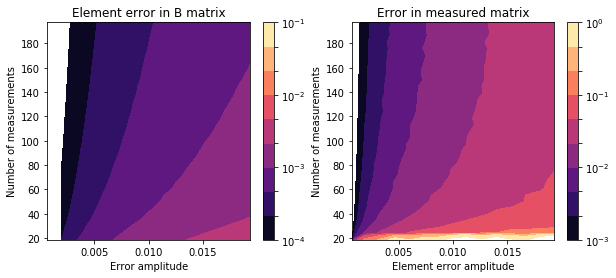

In [70]:
# Parameters
LowThres1 = 1e-4
HighThres1 = 1e-1
Nlevels1 = 3
LowThres2 = 1e-3
HighThres2 = 1
Nlevels2 = 3

# Create levels
lev_min1 = np.floor(np.log10(LowThres1))
lev_max1 = np.ceil(np.log10(HighThres1))
Nlevels1 = (lev_max1-lev_min1) * np.ceil(Nlevels1) +1
levs1 = np.logspace(lev_min1, lev_max1, Nlevels1)
lev_min2 = np.floor(np.log10(LowThres2))
lev_max2 = np.ceil(np.log10(HighThres2))
Nlevels2 = (lev_max2-lev_min2) * np.ceil(Nlevels2) +1
levs2 = np.logspace(lev_min2, lev_max2, Nlevels2)
# Other operations
extension = [0, error_max, medidas_min, medidas_max]
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        result_B,
        levels = levs1,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude")
plt.ylabel("Number of measurements")
plt.title("Element error in B matrix")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
IDimage = plt.contourf(
        result_final,
        levels = levs2,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Element error amplitude")
plt.ylabel("Number of measurements")
plt.title("Error in measured matrix")
plt.colorbar()
IDimage.set_cmap("magma")


## Miscelaneo

Calculo del factor de error a proporcionar para una matriz de Mueller o vector de Stokes.

La pendiente para la matriz de Mueller es: 0.246084071529.
La pendiente para el vector de Stokes es: 0.470027525407.


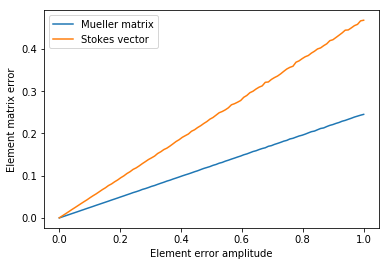

In [68]:
Nerrors = 100
x = np.linspace(0.001,1,Nerrors)
Naverages = 10000
y1 = np.zeros(Nerrors)
y2 = np.zeros(Nerrors)
for indE, error in enumerate(x):    
    average_array1 = np.zeros(Naverages)
    average_array2 = np.zeros(Naverages)
    for indAv in range(Naverages):
        M = error * np.matrix(np.random.randn(4,4))
        average_array1[indAv] = np.linalg.norm(M, ord='fro')
        M = error * np.matrix(np.random.randn(4,1))
        average_array2[indAv] = np.linalg.norm(M, ord='fro')
    y1[indE] = np.mean(average_array1)/16
    y2[indE] = np.mean(average_array2)/4
    
plt.figure(figsize=(6,4))
plt.plot(x, y1)
plt.xlabel("Element error amplitude")
plt.ylabel("Element matrix error")
plt.plot(x, y2)
plt.legend(['Mueller matrix', 'Stokes vector'])


print('La pendiente para la matriz de Mueller es: {}.'.format(np.mean(y1/x)))
print('La pendiente para el vector de Stokes es: {}.'.format(np.mean(y2/x)))
    

In [4]:
print(np.mean(y)*2)

3.9343787898408857
